In [1]:
import os
import math
import numpy as np
import librosa
import hmmlearn.hmm as hmm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Danh sách các nhãn
class_names = ['3.1', '3.2', '3.3', '3.4']

# Số trạng thái của mỗi mô hình HMM tương ứng với mỗi nhãn
states = [4, 3, 3, 3]

In [3]:
def get_mfcc(file_path):
    y, sr = librosa.load(file_path)
    hop_length = math.floor(sr * 0.010) # 10ms hop
    win_length = math.floor(sr * 0.025) # 25ms frame
    # Tính toán MFCC, delta và delta-delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1)) # Chuẩn hóa MFCC
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # Kết hợp các đặc trưng
    return X.T 

In [4]:
def prepare_data(base_directory):
    all_data = {}
    all_labels = {}
    for cname in class_names:
        directory = os.path.join(base_directory, cname)
        file_paths = [os.path.join(directory, i) for i in os.listdir(directory) if i.endswith('.wav')]
        
        data = []
        for file_path in file_paths:
            mfcc_features = get_mfcc(file_path)
            # Thêm dữ liệu MFCC vào danh sách
            data.append(mfcc_features)

        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]
    return all_data, all_labels

train_data, train_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/train')

In [5]:
# # Huấn luyện và lưu mô hình
# def train_and_save_models(all_data, all_labels):
#     if not os.path.exists('D:/PBL5/PBL5_CODE/DemoHMM/model_train'):
#         os.makedirs('D:/PBL5/PBL5_CODE/DemoHMM/model_train')

#     models = {}
#     for idx, cname in enumerate(class_names):
#         start_prob = np.full(states[idx], 0.0)
#         start_prob[0] = 1.0
#         trans_matrix = np.full((states[idx], states[idx]), 0.0)
#         p = 0.5
#         np.fill_diagonal(trans_matrix, p)
#         np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
#         trans_matrix[-1, -1] = 1.0

#         print(f"Training {cname}")

#         models[cname] = hmm.GMMHMM(
#             n_components=states[idx],
#             startprob_prior=start_prob,
#             transmat_prior=trans_matrix,
#             verbose=True,
#             n_iter=300,
#             params='stmc',
#             init_params='mc',
#             random_state=42,
#             algorithm='viterbi',
#             covariance_type='diag',
#             tol=0.001,
#             n_mix=3
#         )

#         models[cname].fit(X=np.vstack(all_data[cname]), lengths=[x.shape[0] for x in all_data[cname]])

#         # Lấy log-likelihood sau mỗi lần lặp
#         log_likelihoods = models[cname].monitor_.history

#         # Vẽ đồ thị
#         plt.plot(log_likelihoods)
#         plt.title('Convergence of the model')
#         plt.xlabel('Iteration')
#         plt.ylabel('Log-likelihood')
#         plt.show()

#         # Lấy log-likelihood sau mỗi lần lặp và chuyển đổi thành danh sách
#         log_likelihoods = list(models[cname].monitor_.history)
#         # Tính sự thay đổi của log-likelihood
#         diffs = [j-i for i, j in zip(log_likelihoods[:-1], log_likelihoods[1:])]
#         plt.plot(diffs)
#         plt.title('Convergence of the model')
#         plt.xlabel('Iteration')
#         plt.ylabel('Change in Log-likelihood')
#         plt.show()

#     # Lưu tất cả các mô hình vào một file model.pkl
#     with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model3.pkl', 'wb') as file:
#         pickle.dump(models, file)

#     print("\nTraining and saving models done!!!")

In [6]:
# Huấn luyện và lưu mô hình
def train_and_save_models(all_data, all_labels):
    if not os.path.exists('D:/PBL5/PBL5_CODE/DemoHMM/model_train'):
        os.makedirs('D:/PBL5/PBL5_CODE/DemoHMM/model_train')

    # Tạo hai đồ thị trống
    fig1, ax1 = plt.subplots()
    ax1.set_title('Convergence of the model')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Log-likelihood')

    fig2, ax2 = plt.subplots()
    ax2.set_title('Convergence of the model')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Change in Log-likelihood')

    models = {}
    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0

        print(f"Training {cname}")

        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            verbose=True,
            n_iter=300,
            params='stmc',
            init_params='mc',
            random_state=42,
            algorithm='viterbi',
            covariance_type='diag',
            tol=0.001,
            n_mix=3
        )

        models[cname].fit(X=np.vstack(all_data[cname]), lengths=[x.shape[0] for x in all_data[cname]])

        # Lấy log-likelihood sau mỗi lần lặp và chuyển đổi thành danh sách
        log_likelihoods = list(models[cname].monitor_.history)
        # Vẽ đường cho log-likelihood
        ax1.plot(log_likelihoods, label=cname)
        # Tính sự thay đổi của log-likelihood
        diffs = [j-i for i, j in zip(log_likelihoods[:-1], log_likelihoods[1:])]
        # Vẽ đường cho sự thay đổi của log-likelihood
        ax2.plot(diffs, label=cname)

    ax1.legend(ncol=2)
    ax2.legend(ncol=2)
    plt.show()

    # Lưu tất cả các mô hình vào một file model.pkl
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model3.pkl', 'wb') as file:
        pickle.dump(models, file)

    print("\nTraining and saving models done!!!")

Training 3.1


         1 -330857.31491975             +nan
         2 -314998.33068297  +15858.98423678
         3 -312398.33019615   +2600.00048682
         4 -311845.06525260    +553.26494355
         5 -311569.13156020    +275.93369240
         6 -311418.42909088    +150.70246931
         7 -311336.07712228     +82.35196860
         8 -311278.57557555     +57.50154673
         9 -311224.46477463     +54.11080093
        10 -311154.71902372     +69.74575091
        11 -311015.48591780    +139.23310592
        12 -310723.53523673    +291.95068107
        13 -310652.10954384     +71.42569289
        14 -310632.55506385     +19.55447999
        15 -310618.30820852     +14.24685533
        16 -310549.32980516     +68.97840336
        17 -310504.32480067     +45.00500449
        18 -310466.94556168     +37.37923899
        19 -310435.28525734     +31.66030433
        20 -310404.61931398     +30.66594336
        21 -310376.59414159     +28.02517239
        22 -310352.30310751     +24.29103407
        23

Training 3.2


         1 -295493.00703654             +nan
         2 -274900.91683559  +20592.09020095
         3 -271502.32603932   +3398.59079627
         4 -270547.73033155    +954.59570777
         5 -270110.72524382    +437.00508772
         6 -269868.84901753    +241.87622630
         7 -269665.57657673    +203.27244080
         8 -269453.85211305    +211.72446367
         9 -269215.13514342    +238.71696963
        10 -269023.19585808    +191.93928535
        11 -268881.25004031    +141.94581777
        12 -268783.68479207     +97.56524825
        13 -268723.89182119     +59.79297088
        14 -268684.65103009     +39.24079110
        15 -268660.81089223     +23.84013786
        16 -268642.69632499     +18.11456724
        17 -268630.96403254     +11.73229245
        18 -268622.85580853      +8.10822401
        19 -268617.64765310      +5.20815542
        20 -268614.57838548      +3.06926763
        21 -268612.34731995      +2.23106553
        22 -268609.76615749      +2.58116246
        23

Training 3.3


         1 -284516.37101467             +nan
         2 -262609.09582730  +21907.27518738
         3 -256733.21171355   +5875.88411374
         4 -254980.03041136   +1753.18130220
         5 -254038.40935398    +941.62105738
         6 -253514.92004949    +523.48930449
         7 -253260.73084091    +254.18920858
         8 -253071.63578121    +189.09505970
         9 -252990.51591846     +81.11986275
        10 -252920.73771835     +69.77820011
        11 -252834.05223821     +86.68548014
        12 -252660.12997015    +173.92226806
        13 -252449.65373910    +210.47623105
        14 -252313.57329957    +136.08043953
        15 -252255.93898151     +57.63431806
        16 -252215.10463127     +40.83435024
        17 -252192.97828086     +22.12635041
        18 -252180.25511472     +12.72316613
        19 -252170.74290274      +9.51221199
        20 -252160.78867317      +9.95422957
        21 -252152.76410735      +8.02456582
        22 -252147.29100403      +5.47310332
        23

Training 3.4


         1 -203066.10126923             +nan
         2 -188870.24598733  +14195.85528190
         3 -187702.48127097   +1167.76471636
         4 -187371.47013413    +331.01113684
         5 -187061.82079315    +309.64934097
         6 -186686.37267826    +375.44811489
         7 -186495.01567879    +191.35699947
         8 -186294.92408041    +200.09159838
         9 -186132.39025348    +162.53382693
        10 -186053.46097088     +78.92928260
        11 -186006.77565588     +46.68531499
        12 -185982.66338369     +24.11227219
        13 -185968.38152981     +14.28185388
        14 -185961.39401960      +6.98751021
        15 -185959.35719753      +2.03682208
        16 -185958.79150780      +0.56568973
        17 -185958.47705329      +0.31445450
        18 -185958.21313023      +0.26392307
        19 -185958.00740991      +0.20572032
        20 -185957.85739127      +0.15001863
        21 -185957.74622191      +0.11116936
        22 -185957.65724825      +0.08897366
        23

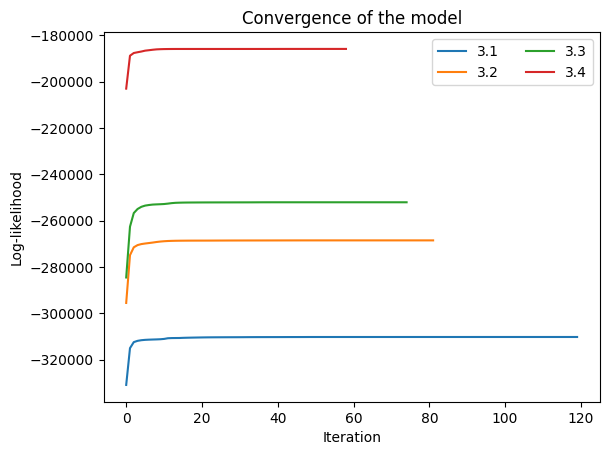

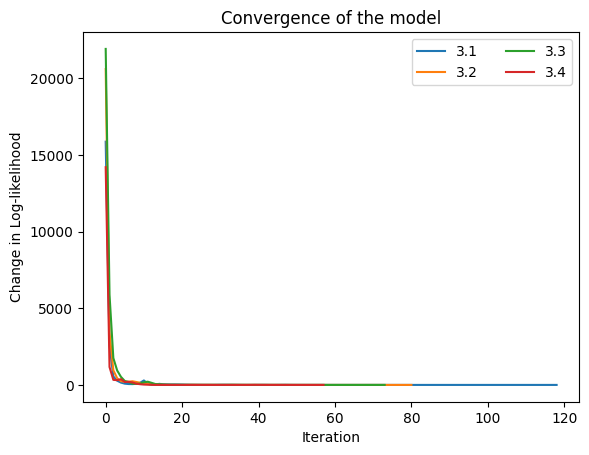


Training and saving models done!!!


In [7]:
# Load mô hình đã huấn luyện
def load_models():
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model3.pkl', 'rb') as file:
        models = pickle.load(file)
    return models

# Huấn luyện và lưu mô hình
train_and_save_models(train_data, train_labels)
# Load mô hình đã huấn luyện
trained_models = load_models()

In [8]:
def classify_test_data(X_test, y_test, models):
    y_true = []
    y_predict = []
    for cname in class_names:
        for mfcc, target in zip(X_test[cname], y_test[cname]):
            scores = [models[cname].score(mfcc) for cname in class_names]
            pred = np.argmax(scores)
            y_predict.append(pred)
            y_true.append(target)

    # In báo cáo phân loại
    report = classification_report(y_true, y_predict, target_names=class_names)
    print(report)

    # In ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_predict)

    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Tính độ chính xác
    accuracy = np.sum(cm.diagonal()) / np.sum(cm)
    accuracy = np.round(accuracy, 4)
    print("Accuracy:", accuracy*100, "%")

              precision    recall  f1-score   support

         3.1       1.00      1.00      1.00        10
         3.2       1.00      1.00      1.00        10
         3.3       1.00      1.00      1.00        10
         3.4       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



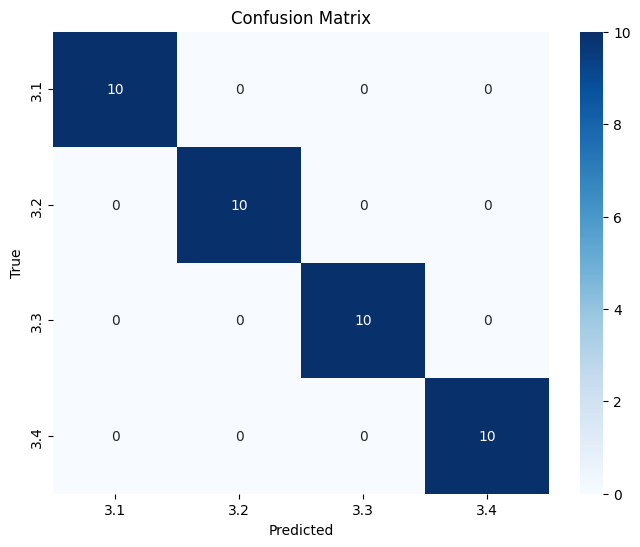

Accuracy: 100.0 %


In [9]:
# Phân loại dữ liệu kiểm tra
test_data, test_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/test')

# Phân loại dữ liệu kiểm tra và xuất báo cáo
classify_test_data(test_data, test_labels, trained_models)

In [10]:
# classify_test_data(train_data, train_labels, trained_models)